In [131]:
import pandas as pd

In [132]:
history_folder = "./League-History"
results_folder = "./analysis_results"

# merge all the csv files from the subfolders into one dataframe, introducing a new column the folder and file name

df = pd.DataFrame()
for year in range(2023, 2024):
    for week in range(1, 18):
        try:
            df_temp = pd.read_csv(f'{history_folder}/{year}/{week}.csv')
            df_temp['year'] = year
            df_temp['week'] = week

            df = pd.concat([df, df_temp], ignore_index=True)

        except:
            print(f'Error reading {history_folder}/{year}/{week}.csv')
            pass

df

,Owner,Team,Rank,QB,Points,RB,Points.1,RB.1,Points.2,WR,...,Opponent_Owner,Opponent,Opponent Total,year,week,RES.1,RES.2,Points.19,Points.20,BN.6
0,David,Too Money to Lose,1,T. Lawrence QB - JAX,16.74,D. Henry RB - TEN,12.9,B. Robinson RB - ATL,17.3,A. Cooper WR - CLE IA,...,David,Dan Money Carpenter,87.30,2023,1,NaN,NaN,NaN,NaN,NaN
1,Martin,Klinga Jaguars,5,J. Burrow QB - CIN IR,3.18,R. Stevenson RB - NE IR,11.9,B. Robinson RB - WAS,13.1,A. Brown WR - PHI Q,...,Johannes,Meine Buam,95.42,2023,1,NaN,NaN,NaN,NaN,NaN
2,Julian,Scary Gary,11,J. Allen QB - BUF,9.04,D. Jackson RB - NYG,-0.7,I. Pacheco RB - KC,7.4,C. Ridley WR - JAX,...,Alexander,Mile High,97.86,2023,1,NaN,NaN,NaN,NaN,NaN
3,Daniel,LA Panthers,3,J. Fields QB - CHI,13.54,J. Dobbins RB - BAL IR View News,10.7,J. Gibbs RB - DET,7.0,J. Jefferson WR - MIN,...,Manuel,Flexorcists,128.24,2023,1,NaN,NaN,NaN,NaN,NaN
4,David,Dan Money Carpenter,12,J. Hurts QB - PHI Q,11.50,K. Walker RB - SEA,8.7,D. Vaughn RB - DAL IR,0.8,O. Beckham WR - BAL IA,...,David,Too Money to Lose,141.74,2023,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,Alexander,Mile High,3,J. Flacco QB - CLE,22.58,S. Barkley RB - NYG,7.3,R. White RB - TB,5.6,D. Adams WR - LV,...,David,Too Money to Lose,90.00,2023,17,-,NaN,-,NaN,NaN
200,Paul,Call is call,9,J. Goff QB - DET,10.84,T. Pollard RB - DAL,5.4,D. Singletary RB - HOU,10.1,M. Evans WR - TB,...,Johannes,Meine Buam,113.44,2023,17,-,NaN,-,NaN,NaN
201,Manuel,Flexorcists,1,P. Mahomes QB - KC IA,11.00,E. Elliott RB - NE,11.0,Z. White RB - LV,13.1,T. Hill WR - MIA,...,Michael,doitforjohnny,150.80,2023,17,-,NaN,-,NaN,NaN
202,Lukas,Kaiserbier,5,L. Jackson QB - BAL IA,36.34,K. Hunt RB - CLE,9.1,B. Hall RB - NYJ,23.1,C. Lamb WR - DAL,...,Julian,Scary Gary,126.96,2023,17,-,NaN,-,NaN,NaN


In [133]:
# remove by weeks (where Opponent is '-')
df = df[df['Opponent'] != '-']

# Parse the Points, Total, and Opponent Total columns as floats, 0 if not a number
df['Points'] = pd.to_numeric(df['Points'], errors='coerce').fillna(0)
df['Total'] = pd.to_numeric(df['Total'], errors='coerce').fillna(0)
df['Opponent Total'] = pd.to_numeric(df['Opponent Total'], errors='coerce').fillna(0)


C:\Users\DavidRaffetseder\AppData\Local\Temp\ipykernel_8868\2825940201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Points'] = pd.to_numeric(df['Points'], errors='coerce').fillna(0)
C:\Users\DavidRaffetseder\AppData\Local\Temp\ipykernel_8868\2825940201.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total'] = pd.to_numeric(df['Total'], errors='coerce').fillna(0)
C:\Users\DavidRaffetseder\AppData\Local\Temp\ipykernel_8868\2825940201.py:7: SettingWithCopyWarning: 
A value is trying to be se

In [134]:
# handle league-specific preprocessing
# comment out the line below if you don't have utils.league_utils
from utils.league_utils import LeagueUtils

df = LeagueUtils.preprocess_league(df)

,Owner,Team,Rank,QB,Points,RB,Points.1,RB.1,Points.2,WR,...,Opponent_Owner,Opponent,Opponent Total,year,week,RES.1,RES.2,Points.19,Points.20,BN.6
0,David,Too Money to Lose,1,T. Lawrence QB - JAX,16.74,D. Henry RB - TEN,12.9,B. Robinson RB - ATL,17.3,A. Cooper WR - CLE IA,...,Haunsch,Dan Money Carpenter,87.30,2023,1,NaN,NaN,NaN,NaN,NaN
1,Martin,Klinga Jaguars,5,J. Burrow QB - CIN IR,3.18,R. Stevenson RB - NE IR,11.9,B. Robinson RB - WAS,13.1,A. Brown WR - PHI Q,...,Johannes,Meine Buam,95.42,2023,1,NaN,NaN,NaN,NaN,NaN
2,Julian,Scary Gary,11,J. Allen QB - BUF,9.04,D. Jackson RB - NYG,-0.7,I. Pacheco RB - KC,7.4,C. Ridley WR - JAX,...,Alexander,Mile High,97.86,2023,1,NaN,NaN,NaN,NaN,NaN
3,Daniel,LA Panthers,3,J. Fields QB - CHI,13.54,J. Dobbins RB - BAL IR View News,10.7,J. Gibbs RB - DET,7.0,J. Jefferson WR - MIN,...,Manuel,Flexorcists,128.24,2023,1,NaN,NaN,NaN,NaN,NaN
4,Haunsch,Dan Money Carpenter,12,J. Hurts QB - PHI Q,11.50,K. Walker RB - SEA,8.7,D. Vaughn RB - DAL IR,0.8,O. Beckham WR - BAL IA,...,David,Too Money to Lose,141.74,2023,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,Alexander,Mile High,3,J. Flacco QB - CLE,22.58,S. Barkley RB - NYG,7.3,R. White RB - TB,5.6,D. Adams WR - LV,...,David,Too Money to Lose,90.00,2023,17,-,NaN,-,NaN,NaN
200,Paul,Call is call,9,J. Goff QB - DET,10.84,T. Pollard RB - DAL,5.4,D. Singletary RB - HOU,10.1,M. Evans WR - TB,...,Johannes,Meine Buam,113.44,2023,17,-,NaN,-,NaN,NaN
201,Manuel,Flexorcists,1,P. Mahomes QB - KC IA,11.00,E. Elliott RB - NE,11.0,Z. White RB - LV,13.1,T. Hill WR - MIA,...,Michael,doitforjohnny,150.80,2023,17,-,NaN,-,NaN,NaN
202,Lukas,Kaiserbier,5,L. Jackson QB - BAL IA,36.34,K. Hunt RB - CLE,9.1,B. Hall RB - NYJ,23.1,C. Lamb WR - DAL,...,Julian,Scary Gary,126.96,2023,17,-,NaN,-,NaN,NaN


In [135]:
df['win'] = df['Total'] > df['Opponent Total']
df['loss'] = df['Total'] < df['Opponent Total']
df['tie'] = df['Total'] == df['Opponent Total']

C:\Users\DavidRaffetseder\AppData\Local\Temp\ipykernel_8868\607255417.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['win'] = df['Total'] > df['Opponent Total']
C:\Users\DavidRaffetseder\AppData\Local\Temp\ipykernel_8868\607255417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = df['Total'] < df['Opponent Total']
C:\Users\DavidRaffetseder\AppData\Local\Temp\ipykernel_8868\607255417.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

,Rank,Points,Points.1,Points.2,Points.3,Points.4,Points.5,Points.6,Points.7,Points.8,...,Points.13,Points.14,Points.15,Points.16,Total,Opponent Total,week,win,loss,tie
year,,,,,,,,,,,,,,,,,,,,,
2023,6.5,18.312653,11.445204,12.305306,12.796429,12.110612,8.318163,11.615408,7.556122,8.066327,...,6.271224,6.323673,5.723367,6.13602,124.016122,124.016122,8.734694,0.5,0.5,0.0


<AxesSubplot:title={'center':'Average Points Per Year'}, xlabel='year'>

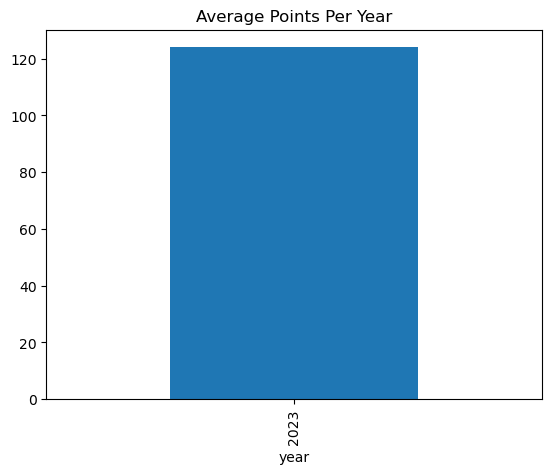

In [137]:
df.groupby(['year']).mean()['Total'].plot(kind='bar', title='Average Points Per Year')

<AxesSubplot:title={'center':'Average Points Per Week'}, xlabel='week'>

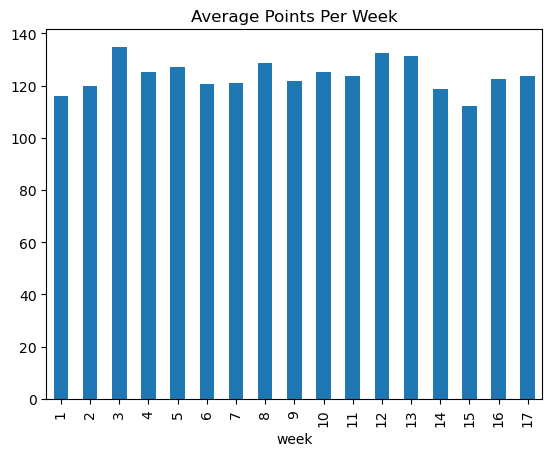

In [138]:
df.groupby(['week']).mean()['Total'].plot(kind='bar', title='Average Points Per Week')

<AxesSubplot:title={'center':'Average League Rank Per Week (after week 2)'}, ylabel='Owner'>

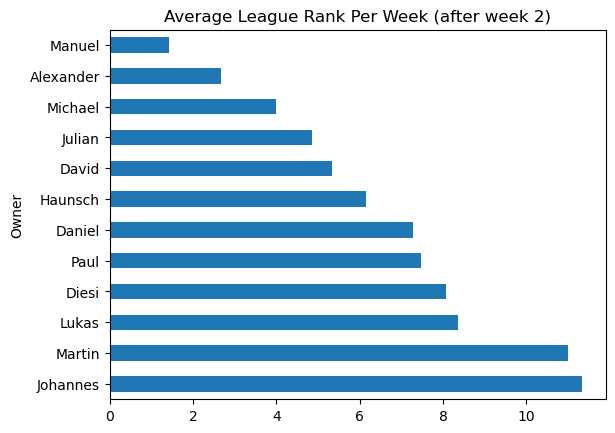

In [139]:
df[df['week'] > 2].groupby(['Owner'])['Rank'].mean().sort_values(ascending=False).plot(kind='barh', title='Average League Rank Per Week (after week 2)')

In [140]:
owners_df = df.groupby(['Owner'])['Owner', 'win', 'loss', 'tie', 'Total', 'Opponent Total'].sum()

owners_df['games'] = owners_df['win'] + owners_df['loss'] + owners_df['tie']
number_of_games_threshold = 20
owners_df = owners_df[owners_df['games'] > number_of_games_threshold]

# calculate win percentage and points per game
owners_df['win_pct'] = owners_df['win'] / owners_df['games']
owners_df['ppg'] = owners_df['Total'] / owners_df['games']
owners_df['opp_ppg'] = owners_df['Opponent Total'] / owners_df['games']

# save to excel
owners_df.to_excel(f'{results_folder}/Owners.xlsx')
owners_df

C:\Users\DavidRaffetseder\AppData\Local\Temp\ipykernel_8868\926196300.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  owners_df = df.groupby(['Owner'])['Owner', 'win', 'loss', 'tie', 'Total', 'Opponent Total'].sum()


,win,loss,tie,Total,Opponent Total,games,win_pct,ppg,opp_ppg
Owner,,,,,,,,,
Alexander,11,6,0,2055.74,1973.96,17,0.647059,120.925882,116.115294
Daniel,8,8,0,2027.28,2096.35,16,0.500000,126.705000,131.021875
David,10,7,0,2212.23,2168.45,17,0.588235,130.131176,127.555882
Diesi,6,10,0,1641.08,1831.60,16,0.375000,102.567500,114.475000
Haunsch,8,8,0,2035.36,2019.56,16,0.500000,127.210000,126.222500
Johannes,7,10,0,2049.06,2107.55,17,0.411765,120.532941,123.973529
Julian,7,9,0,2000.99,2045.59,16,0.437500,125.061875,127.849375
Lukas,8,8,0,2107.70,2031.91,16,0.500000,131.731250,126.994375
Manuel,12,4,0,2145.53,1833.86,16,0.750000,134.095625,114.616250


Various plots about owner stats

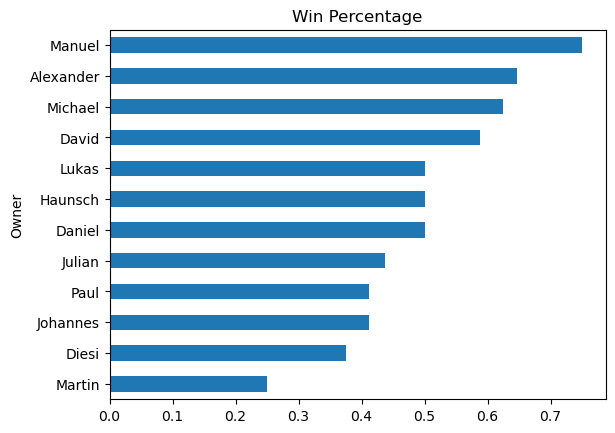

In [141]:
ax = owners_df['win_pct'].sort_values().plot(kind='barh', title='Win Percentage')
_ = ax.set_yticklabels(owners_df['win_pct'].sort_values().index)

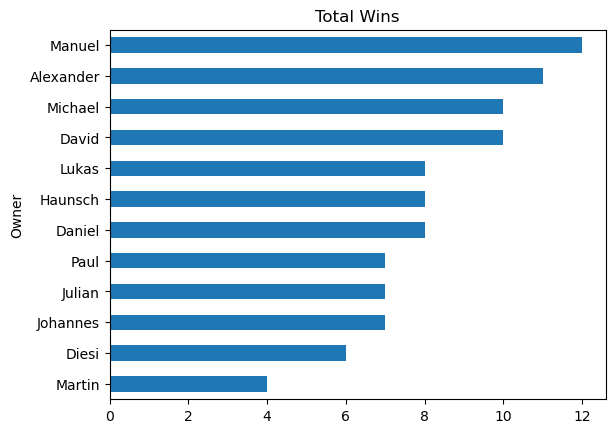

In [142]:
ax = owners_df['win'].sort_values().plot(kind='barh', title='Total Wins')
_ = ax.set_yticklabels(owners_df['win'].sort_values().index)

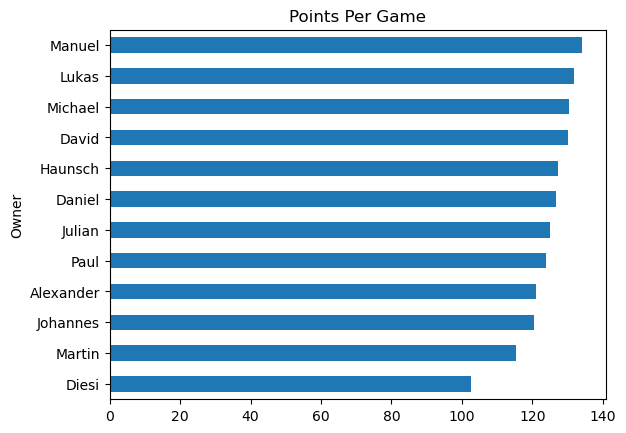

In [143]:
# maybe skewed by half-PPR vs. non-PPR era
ax = owners_df['ppg'].sort_values().plot(kind='barh', title='Points Per Game')
_ = ax.set_yticklabels(owners_df['ppg'].sort_values().index)

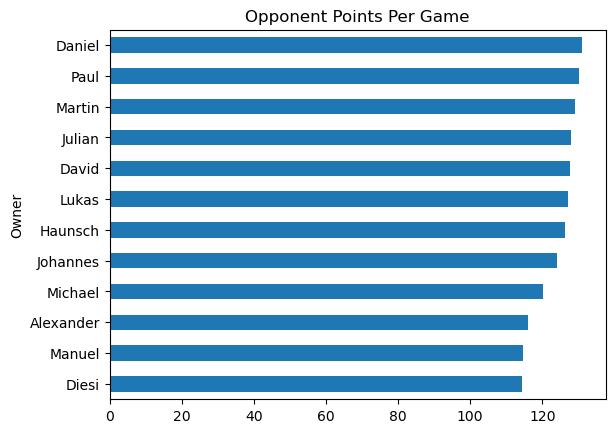

In [144]:
ax = owners_df['opp_ppg'].sort_values().plot(kind='barh', title='Opponent Points Per Game')
_ = ax.set_yticklabels(owners_df['opp_ppg'].sort_values().index)

In [145]:
# get head-to-head matchup records
h2h = pd.DataFrame(df.groupby(['Owner', 'Opponent_Owner'])['Owner', 'Opponent_Owner', 'win', 'loss', 'tie', 'Total', 'Opponent Total'].sum()).reset_index()
h2h

C:\Users\DavidRaffetseder\AppData\Local\Temp\ipykernel_8868\3710812629.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  h2h = pd.DataFrame(df.groupby(['Owner', 'Opponent_Owner'])['Owner', 'Opponent_Owner', 'win', 'loss', 'tie', 'Total', 'Opponent Total'].sum()).reset_index()


,Owner,Opponent_Owner,win,loss,tie,Total,Opponent Total
0,Alexander,Daniel,1,0,0,133.76,120.44
1,Alexander,David,2,0,0,284.30,231.56
2,Alexander,Diesi,1,0,0,120.04,67.48
3,Alexander,Haunsch,0,1,0,88.02,120.98
4,Alexander,Johannes,0,1,0,120.68,159.26
...,...,...,...,...,...,...,...
127,Paul,Julian,2,0,0,282.56,251.12
128,Paul,Lukas,0,1,0,109.92,132.16
129,Paul,Manuel,0,1,0,72.80,140.02
130,Paul,Martin,2,0,0,310.62,239.14


In [146]:
h2h['games'] = h2h['win'] + h2h['loss'] + h2h['tie']
h2h_number_of_games_threshold = 3
h2h = h2h[h2h['games'] > h2h_number_of_games_threshold]

h2h['win_pct'] = h2h['win'] / h2h['games']
h2h['win_diff'] = h2h['win'] - h2h['loss']
h2h['ppg'] = h2h['Total'] / h2h['games']
h2h['opp_ppg'] = h2h['Opponent Total'] / h2h['games']

# save to excel
h2h.to_excel(f'{results_folder}/Head-to-Head.xlsx')
h2h

,Owner,Opponent_Owner,win,loss,tie,Total,Opponent Total,games,win_pct,win_diff,ppg,opp_ppg


Plot top x head-to-head matchups

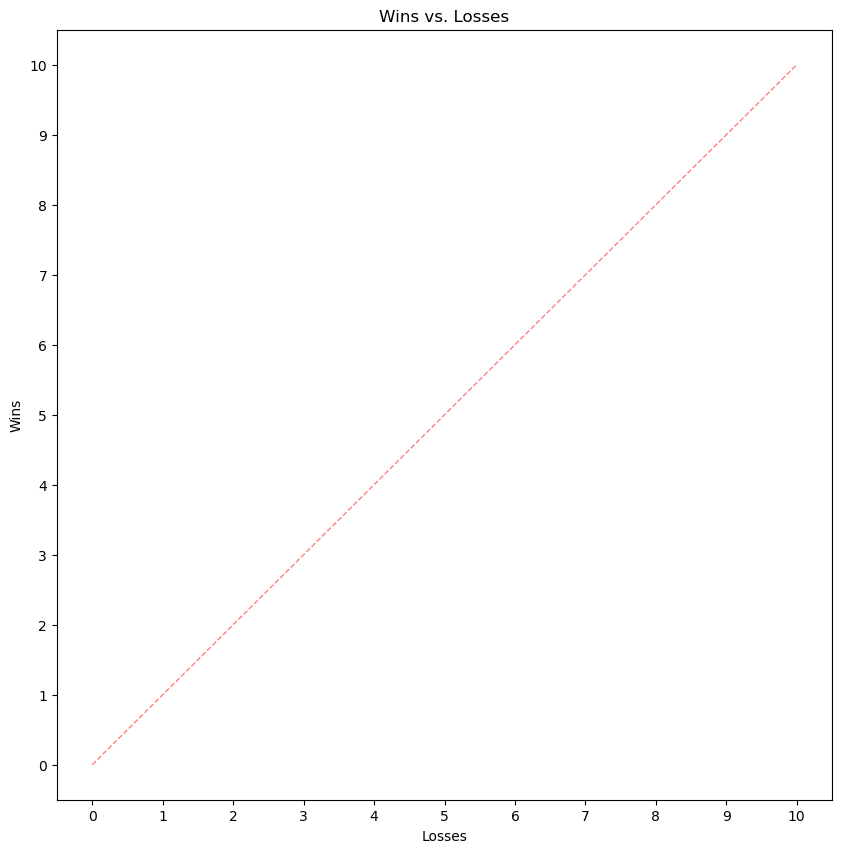

In [147]:
# filter top x win_pct and top 5 win_diff
h2h_win_pct = h2h.sort_values('win_pct', ascending=False).head(3)
h2h_win_diff = h2h.sort_values('win_diff', ascending=False).head(3)

# filter bottom 5 win_pct and top 5 win_diff
h2h_win_pct_l = h2h.sort_values('win_pct', ascending=True).head(3)
h2h_win_diff_l = h2h.sort_values('win_diff', ascending=True).head(3)

# concat the two dataframes without duplicates
h2h_top = pd.concat([h2h_win_pct, h2h_win_diff, h2h_win_pct_l, h2h_win_diff_l])
h2h_top = h2h_top.drop_duplicates()

# plot wins on x-axis, losses on y-axis
ax = h2h_top.plot(kind='scatter', x='loss', y='win', title='Wins vs. Losses', figsize=(10, 10))
_ = ax.set_xlabel('Losses')
_ = ax.set_ylabel('Wins')
_ = ax.set_xticks(range(0, 11))
_ = ax.set_yticks(range(0, 11))

# add labels to each point with random offset to avoid overlapping
import random
for i, row in h2h_top.iterrows():
    ax.annotate(row['Owner'] + ' vs. ' + row['Opponent_Owner'], (row['loss'], row['win'] + random.uniform(-0.3, 0.3)))


# show diagonal line
ax.plot([0, 10], [0, 10], color='red', linestyle='--', linewidth=1, alpha=0.5)


In [148]:
h2h_top

,Owner,Opponent_Owner,win,loss,tie,Total,Opponent Total,games,win_pct,win_diff,ppg,opp_ppg


In [149]:
position_map = {
    'QB': ['Points'],
    'RB': ['Points.1', 'Points.2'],
    'WR': ['Points.3', 'Points.4'],
    'W/R': ['Points.6'],
    'TE': ['Points.5'],
    'DEF': ['Points.8'],
    'K': ['Points.7'],
    'DL': ['Points.9'],
    'LB': ['Points.10'],
    'DB': ['Points.11'],
    'BN': ['Points.12', 'Points.13', 'Points.14', 'Points.15', 'Points.16', 'Points.17']
}

In [150]:
# Define a list to hold our extracted player data
player_data = []

# Iterate over each row in the DataFrame
for _, row in df.iterrows():
    # Iterate over the columns where player data starts at column 4 and step every 2 columns for names/positions/teams
    for i in range(3, 25, 2):
        player_info = row[i]
        try :
            points = float(row[i+1])
        except:
            print(row[i+1])
        win = 1 if row['win'] else 0
        loss = 1 if row['loss'] else 0
        owner = row['Owner']
        total = row['Total']

        # Check if player_info is a string to ensure it's valid data
        if isinstance(player_info, str):
            # Split the player_info into name, position, and team
            parts = player_info.split(" - ")
            name_and_position = parts[0].rsplit(" ", 1)  # Last part is the position, rest is the name
            if len(parts) > 1:
                team = parts[1].split(" ")[0]  # Team name might have status codes (e.g., "IA", "IR"), so take the first part
            else:
                team = "N/A"  # No team info available

            # Check if name_and_position is correctly split into 2 parts (name, position)
            if len(name_and_position) == 2:
                name, position = name_and_position
                if position == '':
                    position = 'DEF'
                    
                # Append this player's info as a dictionary to our list
                player_data.append({"Name": name, "Position": position, "Team": team, "Points": points, "Win": win, "Loss": loss, "Owner": owner, "Total": total})
            else:
                print(f"Error parsing player info: {player_info}")

# Convert the list of player
player_df = pd.DataFrame(player_data)
player_df

-
Error parsing player info: --empty--


,Name,Position,Team,Points,Win,Loss,Owner,Total
0,T. Lawrence,QB,JAX,16.74,1,0,David,141.74
1,D. Henry,RB,TEN,12.90,1,0,David,141.74
2,B. Robinson,RB,ATL,17.30,1,0,David,141.74
3,A. Cooper,WR,CLE,5.20,1,0,David,141.74
4,D. Smith,WR,PHI,14.20,1,0,David,141.74
...,...,...,...,...,...,...,...,...
2150,A. Ekeler,RB,LAC,2.50,1,0,Johannes,113.44
2151,D. Hopkins,K,CLE,0.00,1,0,Johannes,113.44
2152,Ravens DEF,DEF,N/A,10.00,1,0,Johannes,113.44
2153,D. Brown,DL,CAR,6.50,1,0,Johannes,113.44


In [151]:
player_df['Position'].value_counts()

WR     515
RB     463
DEF    199
QB     196
TE     196
LB     196
K      195
DL     195
Name: Position, dtype: int64

<AxesSubplot:title={'center':'Average Points Per Position'}, xlabel='Position'>

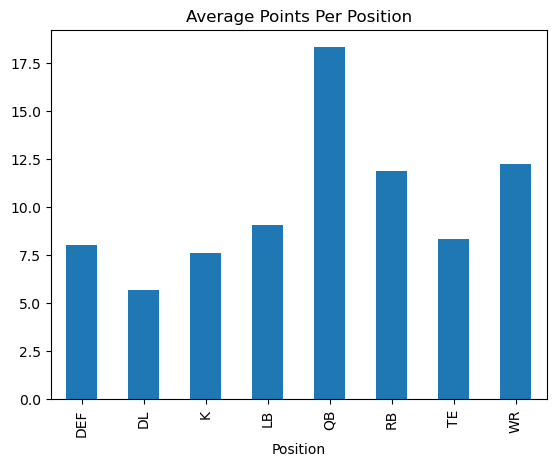

In [152]:
player_df.groupby(['Position']).mean()['Points'].plot(kind='bar', title='Average Points Per Position')

<AxesSubplot:title={'center':'Top Players by Average Points'}, ylabel='Name'>

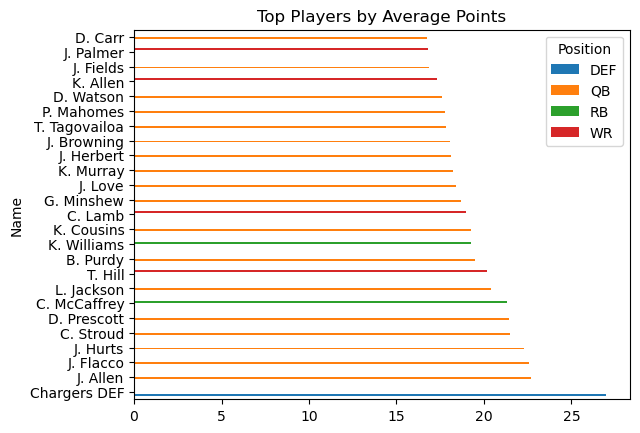

In [153]:
# same as above but color coded by position
player_df.groupby(['Name', 'Position']).mean()['Points'].sort_values(ascending=False).head(25).unstack().plot(kind='barh', title='Top Players by Average Points')

<AxesSubplot:title={'center':'Top Players by Average Points Relative to Position'}, ylabel='Name'>

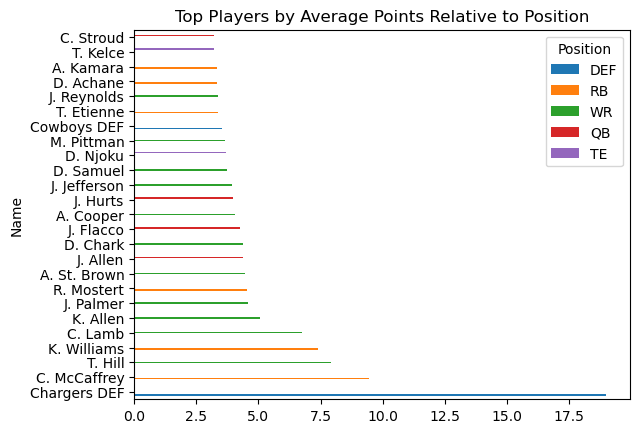

In [154]:
# same as above but relative to the average points per position
player_df['Points Relative'] = player_df['Points'] - player_df.groupby('Position')['Points'].transform('mean')
player_df.groupby(['Name', 'Position']).mean()['Points Relative'].sort_values(ascending=False).head(25).unstack().plot(kind='barh', title='Top Players by Average Points Relative to Position')


<AxesSubplot:title={'center':'Worst Players by Average Points Relative to Position'}, ylabel='Name'>

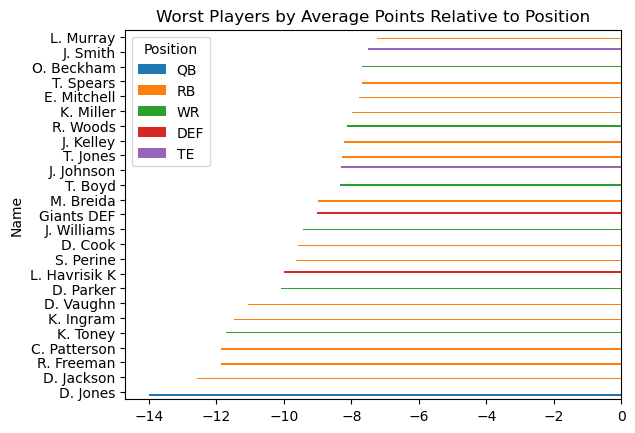

In [155]:
player_df['Points Relative'] = player_df['Points'] - player_df.groupby('Position')['Points'].transform('mean')
player_df.groupby(['Name', 'Position']).mean()['Points Relative'].sort_values(ascending=True).head(25).unstack().plot(kind='barh', title='Worst Players by Average Points Relative to Position')

<AxesSubplot:title={'center':'Points'}, xlabel='Position'>

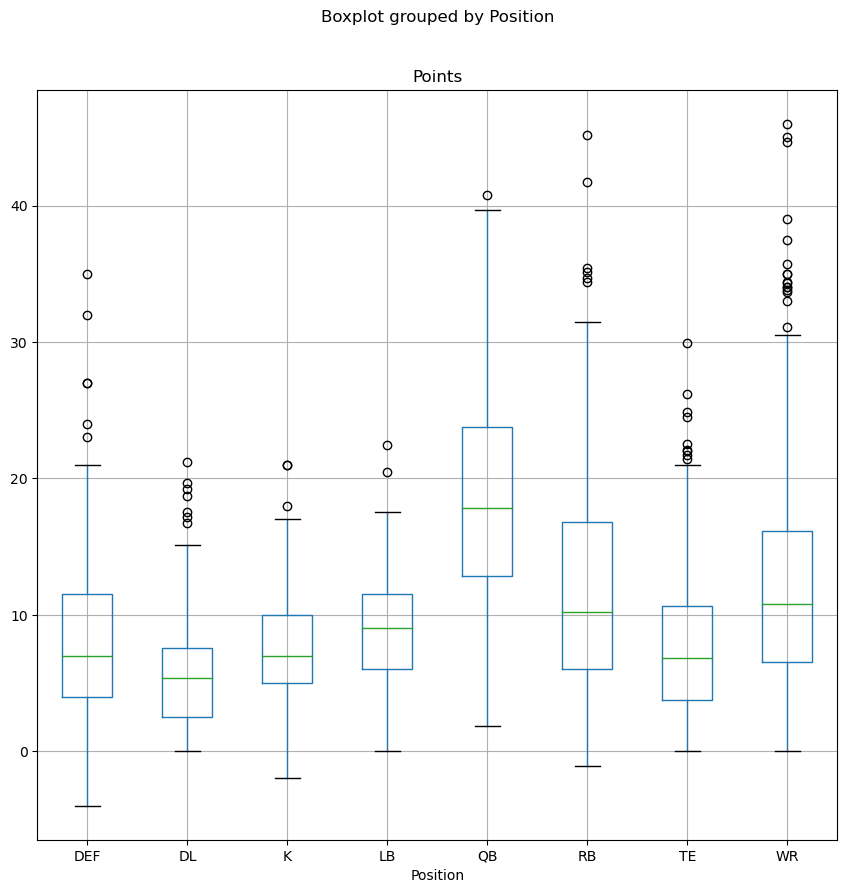

In [156]:
# distribution of points by position
player_df.boxplot(column='Points', by='Position', figsize=(10, 10))

<AxesSubplot:title={'center':'Total'}, xlabel='Owner'>

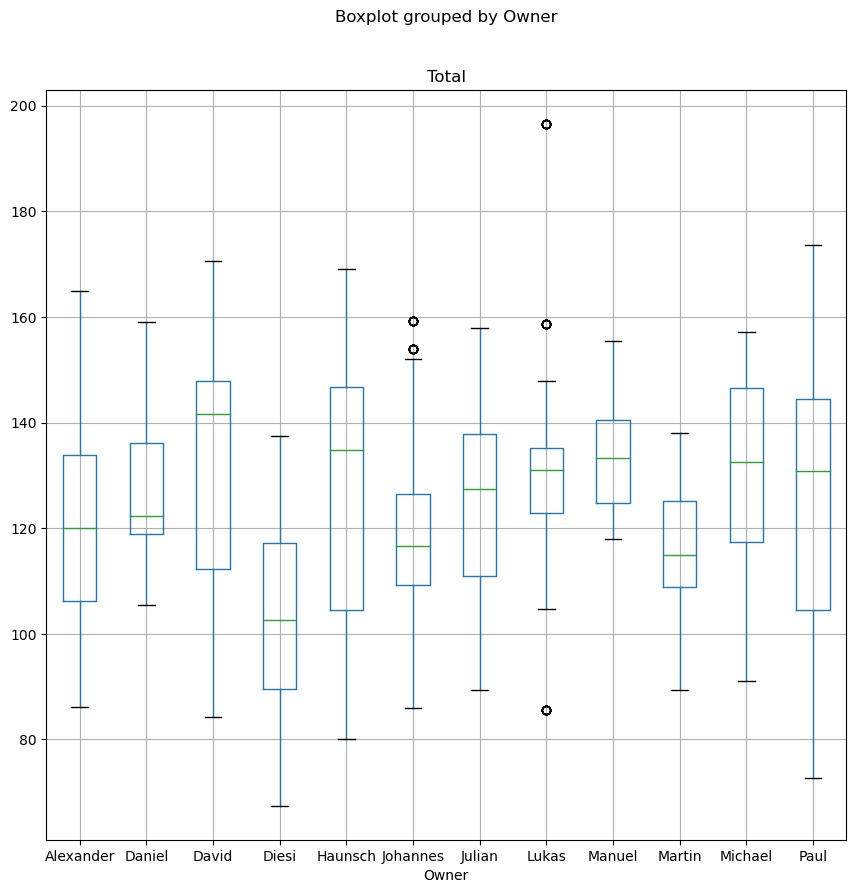

In [160]:
# distribution of points by owner
player_df.boxplot(column='Total', by='Owner', figsize=(10, 10))

<AxesSubplot:title={'center':'Win Percentage by Player (minimum 5 games)'}, ylabel='Name'>

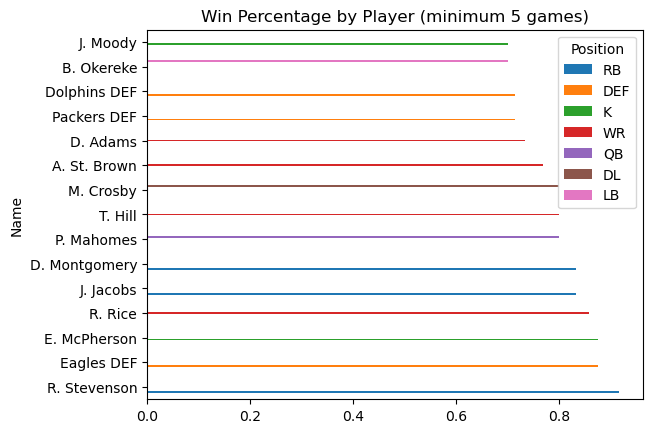

In [158]:
# win percentage by player (minimum 3 games)
grouped = player_df.groupby(['Name', 'Position']).sum()
grouped['games'] = grouped['Win'] + grouped['Loss']
grouped['win_pct'] = grouped['Win'] / grouped['games']

grouped[grouped['games'] > 5].sort_values('win_pct', ascending=False).head(15)['win_pct'].unstack().plot(kind='barh', title='Win Percentage by Player (minimum 5 games)')

<AxesSubplot:title={'center':'Win Percentage by Player (minimum 5 games)'}, ylabel='Name'>

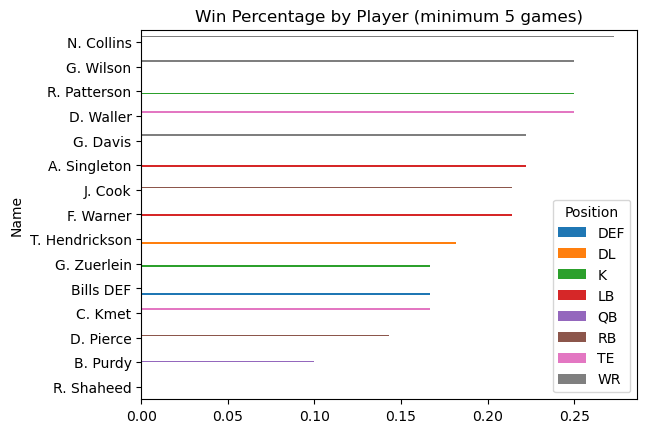

In [159]:
grouped[grouped['games'] > 5].sort_values('win_pct', ascending=True).head(15)['win_pct'].unstack().plot(kind='barh', title='Win Percentage by Player (minimum 5 games)')

